# LoopGAN — Loop generation with StyleGAN2 and MelGAN

In [1]:
import argparse
import torch
from torchvision import utils
from model_drum import Generator
import sys
sys.path.append('./melgan')
from modules import Generator_melgan
import os, random
import librosa
import soundfile as sf
import numpy as np
from utils import *
import IPython.display as ipd

### Download a pre-trained model in advance

``` 
$ gdown -O drumbeats1_230000.pt 1B3ZWTJFuZbPPH4uIIz-pCcBTLu9-w4nw
```

In [1]:

# Constants - do not change! 
N_LATENT = 512
N_MLP = 8
SIZE_OUTPUT = 64 # size of output image
TRUNCATION = 1
TRUNCATION_MEAN = 4096
SR = 44100

# Number of samples (loops) in a batch
n_samples = 4  # batch size

# name of pre-trained StyleGAN2 model
CHECKPOINT = "./drumbeats1_230000.pt" 

# mean / std of Spectrograms of training data. used for the conversion from generated spectrograms into wav files
DATAPATH = "./data/drumbeats_1bar/" 

# name of pre-trained MelGAN model
MELGAN_MODEL_NAME = "best_netG.pt"

# GANSpace
N_PCA_COMPS = 4

# Use "cuda" if you have GPUs on your machine
device_name = "cpu"


### Load models

In [3]:
# Load a StyleGAN2 model
generator = Generator(SIZE_OUTPUT, N_LATENT, N_MLP, channel_multiplier=2).to(device_name)
checkpoint = torch.load(CHECKPOINT, map_location=torch.device(device_name))

generator.load_state_dict(checkpoint["g_ema"], strict=False)

if TRUNCATION < 1:
    with torch.no_grad():
        mean_latent = generator.mean_latent(TRUNCATION_MEAN)
else:
    mean_latent = None

In [4]:
# Load a MelGAN model
def load_vocoder(device_name):
    feat_dim = 80
    mean_fp = f'{DATAPATH}/mean.mel.npy'
    std_fp = f'{DATAPATH}/std.mel.npy'
    v_mean = torch.from_numpy(np.load(mean_fp)).float().view(1, feat_dim, 1).to(device_name)
    v_std = torch.from_numpy(np.load(std_fp)).float().view(1, feat_dim, 1).to(device_name)
    
    vocoder_config_fp = './melgan/args.yml'
    vocoder_config = read_yaml(vocoder_config_fp)

    n_mel_channels = vocoder_config.n_mel_channels
    ngf = vocoder_config.ngf
    n_residual_layers = vocoder_config.n_residual_layers

    vocoder = Generator_melgan(n_mel_channels, ngf, n_residual_layers).to(device_name)
    vocoder.eval()

    vocoder_param_fp = os.path.join('./melgan', MELGAN_MODEL_NAME)
    vocoder.load_state_dict(torch.load(vocoder_param_fp, map_location=torch.device(device_name)), strict=False)

    return vocoder, v_mean, v_std

VOCODER, V_MEAN, V_STD = load_vocoder(device_name)

def vocode(sample, vocoder=VOCODER, v_mean=V_MEAN, v_std=V_STD):
    de_norm = sample.squeeze(0) * v_std + v_mean
    audio_output = vocoder(de_norm)
    return audio_output

# GANSpace 
Härkönen, Erik, Aaron Hertzmann, Jaakko Lehtinen, and Sylvain Paris. 2020. “GANSpace: Discovering Interpretable GAN Controls.” arXiv [cs.CV]. arXiv. http://arxiv.org/abs/2004.02546.

In [5]:
from sklearn.decomposition import PCA

# Generate random W (style vectors) with random Z 
randz = torch.randn(2000, N_LATENT, device=device_name) 
randw = generator.get_latent(randz).detach().cpu().numpy()

# Find principal components using PCA 
pca = PCA(n_components=N_PCA_COMPS)
pca.fit(randw)
pcomponents = torch.tensor(pca.components_)
print(pcomponents)

tensor([[ 0.0715,  0.0847,  0.0277,  ...,  0.0113, -0.0032, -0.0152],
        [-0.0728,  0.0187, -0.0254,  ..., -0.0051, -0.0264,  0.0248],
        [ 0.0027, -0.0225, -0.0491,  ..., -0.0087, -0.0156,  0.0087],
        ...,
        [ 0.0859,  0.0226,  0.0895,  ...,  0.0216,  0.0157, -0.0080],
        [ 0.0624,  0.0152,  0.1162,  ..., -0.0266, -0.0340, -0.0174],
        [-0.0168,  0.0256, -0.0626,  ...,  0.0049,  0.0438, -0.0203]])


### Generation

To make it easier to handle on Max/MSP, generated loops is saved as a wav file with `n_samples` channels. (default: 4ch)

In [8]:
from pydub import AudioSegment

prev_w = None

# Interpolation of z 
def get_w(w, coefs, scale=1.0):
    coefs = coefs[:N_PCA_COMPS]
    w_diff = pcomponents * torch.tensor([coefs]).T
    print(w_diff.shape, w.shape)
    for i in range(w.shape[0]): # batch
        for j in range(w_diff.shape[0]):
            w[i] += w_diff[j]       
    return w

# main function
# g_ema: stylegan generator
# center_z: to specify the input latent z 
# trucation: GAN trucation value
# variation: the scale of noise added to center_z (= vatiation in a batch)
def generate(g_ema=generator, center_z=None, use_prev_w = False, truncation=TRUNCATION, variation=0.10, coef=None):
    global prev_w

    print("generating...")

    with torch.no_grad():
        g_ema.eval()
        
        if not use_prev_w or prev_w == None:
            if center_z is None:
                # random init
                sample_z = torch.randn(1, N_LATENT, device=device_name)
                sample_z = sample_z.repeat(n_samples, 1) +  torch.randn(n_samples, N_LATENT, device=device_name) * variation
            else:
                # use specific latent z
                sample_z = center_z + torch.randn(n_samples, N_LATENT, device=device_name) * variation
            sample_z = sample_z.float()
            
            # Generate!!!            
            sample_w = g_ema.get_latent(sample_z)
        else:
            sample_w = prev_w
            print("use prev", sample_w[0][:3])

        # store for the next round
        prev_w = sample_w.detach().clone()

        if coef:
            sample_w = get_w(sample_w, coef)
        
        print("use", sample_w[0][:3])
            
        sample_w = sample_w.unsqueeze(1).repeat(1, N_LATENT, 1)    
        sample, _ = g_ema([sample_w], truncation=truncation, truncation_latent=mean_latent, input_is_latent=True)

        # Saving tje generated spectrogram image
        randid = random.randint(0, 10000)
        imagepath = f'/tmp/img_{randid}.png'
        utils.save_image(sample, imagepath, nrow=1, normalize=True, range=(-1, 1))
    
        # Saving multi channel audio file
        filepath = f'/tmp/gem_{randid}.wav'
        channels = [] 
        numpy_chs = []  # for numpy array
        # convert (n_samples) spectrogram into audio, one by one 
        for i in range(n_samples):
            audio_output = vocode(sample[i])
            audio_output = audio_output.squeeze().detach().cpu().numpy() 
            numpy_chs.append(audio_output)
            
            channel = AudioSegment( (audio_output*np.iinfo(np.int16).max).astype("int16").tobytes(), sample_width=2, # 16 bit 
                    frame_rate=SR, channels=1)
            channels.append(channel)
        # save as a wav file with (n_samples) channel
        multich = AudioSegment.from_mono_audiosegments(*channels)
        multich.export(filepath, format="wav")
        
        return filepath, imagepath, np.array(numpy_chs)


### Test

Let's generate random loops with random input latent z

generating...
use tensor([2.9460, 3.5087, 3.1056])


/Users/nao/anaconda3/envs/aidj3/lib/python3.8/site-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(


shape: (4, 81920)


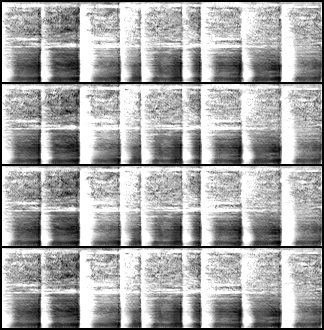

In [9]:
# random generation 
_,  imagepath, audio_output = generate(variation=0.0)

print("shape:", audio_output.shape)

# display the generated spectrogram
ipd.display(ipd.Image(filename=imagepath))


# play the first channel
ipd.display(ipd.Audio(audio_output[0], rate=SR))

#### Stereo effect
Small gausian noise can be added to the input latent vector z. If you play the first and second sample in the generated batch as a stereo audio file, then you'll get an interesting stereo effect. Try different numbers! 

generating...
use tensor([ 1.7155, -0.1304,  3.0884])


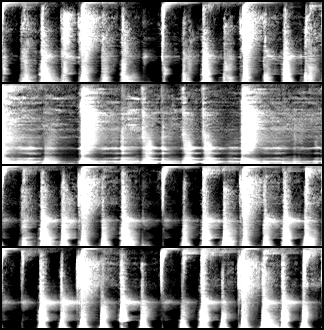

In [10]:
_,  imagepath, audio_output = generate(variation=0.35)

ipd.display(ipd.Audio(audio_output[:2], rate=SR)) # stereo 

ipd.display(ipd.Image(filename=imagepath))


### OSC server/client for Max/MSP

In [11]:
from pythonosc import dispatcher
from pythonosc import osc_server, udp_client
import os, random

# client
client = udp_client.SimpleUDPClient('127.0.0.1', 10018)

# generate randomly
def generate_random(unused_addr, x1,x2,x3,x4,x5,x6,x7,x8, variation=0.1):
    audiopath, imagepath, _ = generate(center_z=None, use_prev_w=False, variation=variation, coef = [x1,x2,x3,x4,x5,x6,x7,x8]) # random sample
    client.send_message("/generated", (audiopath, imagepath)) # init both R and L
    
# morphing
def generate_xy(unused_addr, x1,x2,x3,x4,x5,x6,x7,x8, variation=0.0):
    audiopath, imagepath, _  = generate(center_z=None, use_prev_w=True, variation=variation, coef = [x1,x2,x3,x4,x5,x6,x7,x8]) # random sample
    client.send_message("/generated", (audiopath, imagepath))

# server
dispatcher = dispatcher.Dispatcher()
dispatcher.map("/generate_random", generate_random)
dispatcher.map("/generate_xy", generate_xy)

server = osc_server.ThreadingOSCUDPServer(
    ('localhost', 10015), dispatcher)
print("Serving on {}".format(server.server_address))
server.serve_forever()




Serving on ('127.0.0.1', 10015)
generating...
use prev tensor([ 1.7155, -0.1304,  3.0884])
torch.Size([8, 512]) torch.Size([4, 512])
use tensor([ 1.7155, -0.1304,  3.0884])
generating...
use prev tensor([ 1.7155, -0.1304,  3.0884])
torch.Size([8, 512]) torch.Size([4, 512])
use tensor([ 1.7155, -0.1304,  3.0884])
generating...
use prev tensor([ 1.7155, -0.1304,  3.0884])
torch.Size([8, 512]) torch.Size([4, 512])
use tensor([1.8372, 0.0137, 3.1356])
generating...
use prev tensor([ 1.7155, -0.1304,  3.0884])
torch.Size([8, 512]) torch.Size([4, 512])
use tensor([1.8372, 0.0137, 3.1356])
generating...
use prev tensor([ 1.7155, -0.1304,  3.0884])
torch.Size([8, 512]) torch.Size([4, 512])
use tensor([1.9449, 0.1413, 3.1774])
generating...
use prev tensor([ 1.7155, -0.1304,  3.0884])
torch.Size([8, 512]) torch.Size([4, 512])
use tensor([ 1.5178, -0.3646,  3.0116])
generating...
use prev tensor([ 1.7155, -0.1304,  3.0884])
torch.Size([8, 512]) torch.Size([4, 512])
use tensor([ 1.4732, -0.4174, 